# Imports

In [1]:
from cytoflow import *
import os

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style(
    'ticks',
    {
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'font_color': 'k',
        'axes.edgecolor': 'k',
        'xtick.color': 'k',
        'ytick.color': 'k',
    },
)
sns.set_context('talk', font_scale=1.0)

# Loading Tubes

In [40]:
plasmid_dict = {
    79: "ANM2 - KIBRA",
    80: "BIN1 - FOXO3",
    91: "NOTC2 - KIBRA",
    134: "MYBA - ZN473",
    192: "ANM2 - Rand124",
    193: "Rand124 - KIBRA",
    194: "NOTC2 - Rand124",
    196: "ANM2 - NOTC2",
    198: "MYBA - Rand124",
    199: "Rand124 - ZN473",
    201: "BIN1 - Rand124",
    202: "Rand124 - FOXO3",
}
plasmids = sorted(list(plasmid_dict.keys()))

In [41]:
def get_tube(day, replicate, plasmid):
    letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
    numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    layout = [[192, 193, 194, 79, 196, 91], [198, 199, 134, 201, 202, 80]]
    for row in layout:
        if plasmid in row:
            r = layout.index(row) + 2 * (replicate - 1)
            c = row.index(plasmid) + 6 * (day != 0)
            return (
                "./axm-20220824_actsyn_d2dox-20220824-1414/"
                + letters[r]
                + str(numbers[c])
                + ".fcs"
            )

In [42]:
tubeslist = []
for day in [0, 2]:
    for plasmid in plasmids:
        for replicate in [1, 2]:
            tubeslist.extend(
                [
                    Tube(
                        conditions={
                            "plasmid": plasmid,
                            "day": day,
                            "description": plasmid_dict[plasmid],
                            "replicate": replicate,
                        },
                        file=get_tube(day, replicate, plasmid),
                        conditions_list=["plasmid", "day", "description", "replicate"],
                    )
                ]
            )
print("Loaded", len(tubeslist), "tubes")

Loaded 48 tubes


In [43]:
%%time

op0 = ImportOp(
    conditions={
        "plasmid": "category",
        "day": "float",
        "replicate": "float",
        "description": "category",
    },
    tubes=tubeslist,
    channels={
        "mCitrine-A": "mCitrine-A",
        "mCherry-A": "mCherry-A",
        "FSC 488/10-A": "FSC 488/10-A",
        "SSC 488/10-A": "SSC 488/10-A",
    },
)
ex0 = op0.apply()
ex0.data.head()

CPU times: user 3.11 s, sys: 315 ms, total: 3.42 s
Wall time: 3.49 s


,FSC 488/10-A,SSC 488/10-A,day,description,mCherry-A,mCitrine-A,plasmid,replicate
0,614823424.0,288971520.0,0.0,ANM2 - KIBRA,337234432.0,1688320.0,79,1.0
1,671013632.0,352127488.0,0.0,ANM2 - KIBRA,86745088.0,2579712.0,79,1.0
2,654321920.0,301587200.0,0.0,ANM2 - KIBRA,133310208.0,1481216.0,79,1.0
3,633477632.0,392356352.0,0.0,ANM2 - KIBRA,256325376.0,2531840.0,79,1.0
4,563697152.0,329208576.0,0.0,ANM2 - KIBRA,173319168.0,1849088.0,79,1.0


# Gate for Live Cells

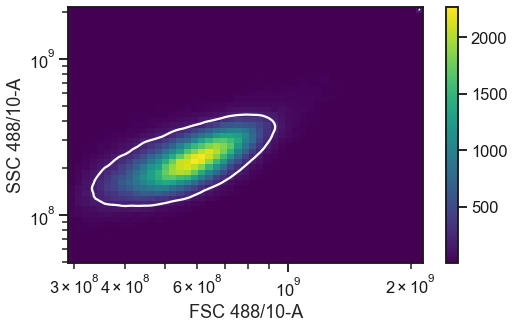

In [44]:
dens_op = DensityGateOp(
    name = 'P1',
    xchannel='FSC 488/10-A',
    xscale = 'log',
    ychannel='SSC 488/10-A',
    yscale = 'log',
    keep = 0.9)

dens_op.estimate(ex0)
ex1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height = 5)

In [45]:
ex1.data.groupby('P1').size()

P1
False     23216
True     219829
dtype: int64

# Gate on mCherry

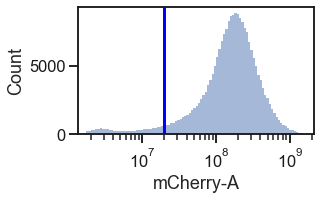

In [46]:
op_2 = ThresholdOp(
    name='mCherry', threshold=2e7, channel='mCherry-A')
ex_2 = op_2.apply(ex1)
op_2.default_view(
    subset='(P1==True)', scale='log').plot(ex_2)

In [47]:
ex_2.data.groupby(['plasmid', 'mCherry']).size()

plasmid  mCherry
79       False        535
         True       12882
80       False       1293
         True       22411
91       False        752
         True        9831
134      False       2170
         True        7513
192      False        715
         True       16481
193      False        850
         True       19108
194      False       1107
         True       18851
196      False       1045
         True       18280
198      False       1575
         True       21466
199      False       1256
         True       29809
201      False       1754
         True       25975
202      False       1501
         True       25885
dtype: int64

# Export data

In [48]:
ex_2.data.to_csv('./data/all_cells_live_mch_gated.csv', index = False)